<a href="https://colab.research.google.com/github/j1zha/DSC_180B/blob/main/transformer_nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
pip install scikit-learn matplotlib pandas numpy yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [ ]:
start_date = "2024-01-01"
end_date = datetime.now()
nvda_data = yf.download("NVDA", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler()
nvda_data_scaled = scaler.fit_transform(nvda_data[['Close']])
seq_length = 10
X, Y = [], []

for i in range(len(nvda_data_scaled) - seq_length):
    X.append(nvda_data_scaled[i:i+seq_length])
    Y.append(nvda_data_scaled[i+seq_length])

X, Y = np.array(X), np.array(Y)

X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=3, dim_feedforward=256, output_dim=1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_layer = nn.Linear(input_dim, d_model) #linear transformation transform 1D to 64D
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_length, d_model))  # Positional encoding to make models
        # know which days are more important

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=nhead,
                                                    dim_feedforward=dim_feedforward,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers) #Using self attention to learn the relations
        # between different days. Self attention assign different weights on different days since to find patterns.

        self.fc = nn.Linear(d_model, output_dim) # Apply a fully connected (FC) layer to convert the final output to one number.

    def forward(self, x):
        x = self.input_layer(x)
        x = x + self.pos_encoder
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x
# Select the last time stamp for the output
model = TimeSeriesTransformer()


In [ ]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/50], Loss: 0.6348
Epoch [10/50], Loss: 0.0453
Epoch [20/50], Loss: 0.0475
Epoch [30/50], Loss: 0.0065
Epoch [40/50], Loss: 0.0105


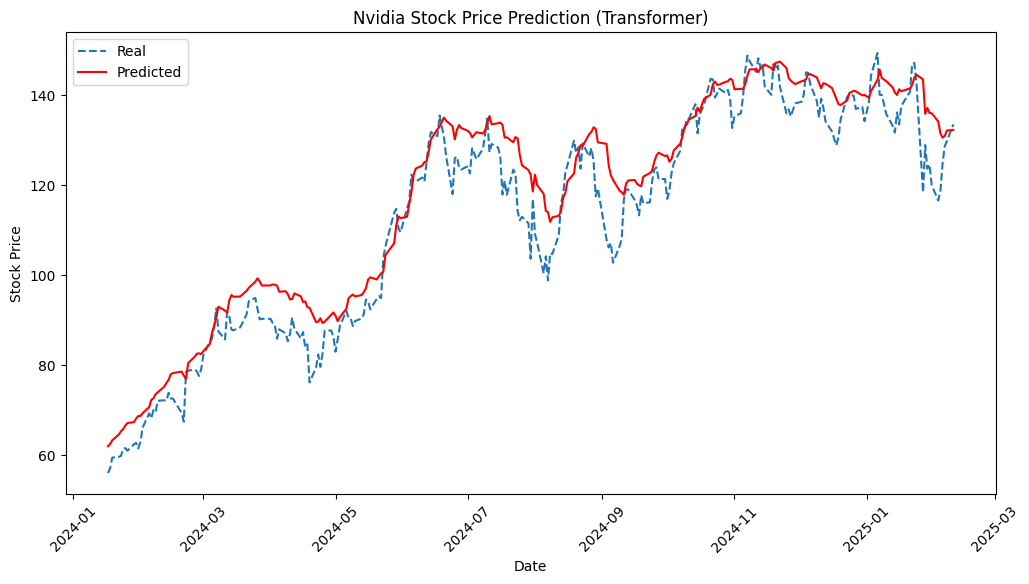

In [ ]:
model.eval()
predictions = model(X_train).detach().numpy()

predictions = scaler.inverse_transform(predictions)
Y_real = scaler.inverse_transform(Y_train.numpy())

dates = nvda_data.index[seq_length:]


plt.figure(figsize=(12,6))
plt.plot(dates, Y_real, label="Real", linestyle="dashed")
plt.plot(dates, predictions, label="Predicted", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Prediction (Transformer)")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(Y_real, predictions))
print(f"RMSE: {rmse:.4f}")

RMSE: 6.1843


In [ ]:
pip install properscoring

In [ ]:
from properscoring import crps_gaussian
sigma = np.std(Y_real - predictions)
crps = np.mean(crps_gaussian(Y_real, predictions, sigma))
print(f"CRPS: {crps:.4f}")

CRPS: 3.4697


# "The Transformer model takes past stock prices as input and uses self-attention to learn patterns between different days. It applies positional encoding to capture time order and processes the data through multiple Transformer encoder layers. The model then extracts the last time step’s output and uses a fully connected layer to generate the final stock price prediction."

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
nvda_close = nvda_data[['Close']].values

scaler = MinMaxScaler()
nvda_close_scaled = scaler.fit_transform(nvda_close)


seq_length = 10
X, Y = [], []

for i in range(len(nvda_close_scaled) - seq_length):
    X.append(nvda_close_scaled[i:i+seq_length])
    Y.append(nvda_close_scaled[i+seq_length])

X, Y = np.array(X), np.array(Y)

X_train = torch.tensor(X, dtype=torch.float32).unsqueeze(1).squeeze(-1)
Y_train = torch.tensor(Y, dtype=torch.float32)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: torch.Size([268, 1, 10])
Y_train shape: torch.Size([268, 1])


In [ ]:
class TemporalConvNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3):
        super(TemporalConvNet, self).__init__()

        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=2, dilation=2)
        self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=4, dilation=4)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=8, dilation=8)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x[:, :, -1]
        x = self.fc(x)
        return x

model = TemporalConvNet(input_dim=1, hidden_dim=64, output_dim=1)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [0/50], Loss: 0.3663
Epoch [10/50], Loss: 0.0346
Epoch [20/50], Loss: 0.0281
Epoch [30/50], Loss: 0.0129
Epoch [40/50], Loss: 0.0076


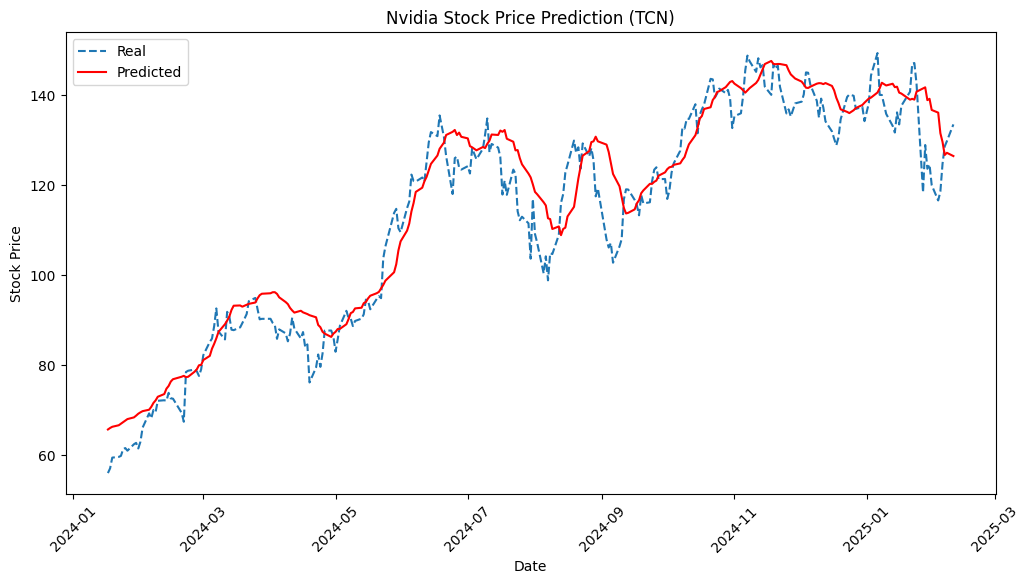

In [ ]:

model.eval()
predictions = model(X_train).detach().numpy()

predictions = scaler.inverse_transform(predictions)
Y_real = scaler.inverse_transform(Y_train.numpy())

rmse = np.sqrt(mean_squared_error(Y_real, predictions))

try:
    from properscoring import crps_gaussian
    sigma = np.std(Y_real - predictions)
    crps = np.mean(crps_gaussian(Y_real, predictions, sigma))
except ModuleNotFoundError:
    crps = None

dates = nvda_data.index[seq_length:]

plt.figure(figsize=(12,6))
plt.plot(dates, Y_real, label="Real", linestyle="dashed")
plt.plot(dates, predictions, label="Predicted", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Prediction (TCN)")
plt.xticks(rotation=45)
plt.show()


In [ ]:
rmse, crps

(7.5522752478758175, 4.334747)